# Analysis of different strategies for segmentation

In [43]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from scipy.stats import multivariate_normal
from src.utils.histograms import change_color_space

In [44]:
# Directory containing the images
image_dir = 'data/qsd2_w1'

In [45]:
# List to store the images
images = []
color_space='HSV'

# Read images from the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = change_color_space(img, color_space)
        images.append(img)

In [46]:
def get_border_pixel_values(img, border_width=10):
    """
    Get the pixel values of the border of a single channel image
    """

    assert len(img.shape) == 2, "The input image should have a single channel"

    border_pixels = np.concatenate((img[:border_width, :].flatten(),
                                    img[-border_width:, :].flatten(),
                                    img[:, :border_width].flatten(),
                                    img[:, -border_width:].flatten()
                                    ))
    
    return border_pixels

In [71]:

def create_histogram(data, bins=255):
    """
    Create a histogram from a list of values.

    Parameters:
    - data: List or numpy array of values
    - bins: Number of bins for the histogram

    Returns:
    - hist: The values of the histogram
    - bin_edges: The edges of the bins
    """
    hist, bin_edges = np.histogram(data, bins=bins)
    return hist, bin_edges

def plot_histogram(hist, bin_edges):
    """
    Plot a histogram with lines indicating the mean and standard deviation.

    Parameters:
    - hist: The values of the histogram
    - bin_edges: The edges of the bins
    """
    # Calculate mean and standard deviation
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    mean = np.average(bin_centers, weights=hist)
    std_dev = np.sqrt(np.average((bin_centers - mean) ** 2, weights=hist))
    
    # Plot histogram
    plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', alpha=0.6, color='g', label='Histogram')
    
    # Plot mean and std deviation lines
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(mean + std_dev, color='b', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
    plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')

    # Labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram with Mean and Std Deviation')
    plt.legend()
    plt.show()

def create_2d_gaussian(data_x, data_y):
    """
    Create a 2D Gaussian distribution based on the means and standard deviations of normalized input data.

    Parameters:
    - data_x: Numpy array of x values
    - data_y: Numpy array of y values

    Returns:
    - z: 2D Gaussian distribution values
    """
    # Normalize data
    #normalized_x = (data_x - np.mean(data_x)) / np.std(data_x)
    #normalized_y = (data_y - np.mean(data_y)) / np.std(data_y)

    mean_x = np.mean(data_x)
    mean_y = np.mean(data_y)
    std_x = np.std(data_x)
    std_y = np.std(data_y)

    # Create a meshgrid for normalized x and y values
    x = np.linspace(mean_x - 3 * std_x, mean_x + 3 * std_x, 100)
    y = np.linspace(mean_y - 3 * std_y, mean_y + 3 * std_y, 100)
    X, Y = np.meshgrid(x, y)

    # Calculate the 2D Gaussian distribution
    z = (1 / (2 * np.pi * std_x * std_y)) * np.exp(-0.5 * (((X - mean_x) ** 2 / std_x ** 2) + ((Y - mean_y) ** 2 / std_y ** 2)))
    return z

def plot_2d_gaussian(z):
    """
    Plot a 2D Gaussian distribution.

    Parameters:
    - z: 2D Gaussian distribution values
    """
    plt.imshow(z, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis', norm=Normalize(vmin=0, vmax=z.max()))
    plt.colorbar(label='Probability Density')
    plt.title('2D Gaussian Distribution')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


In [72]:
# Choose an image from the list
img = images[0]

In [73]:
# Get image channels
h, s, v = cv2.split(img)

In [74]:
h_border_values = get_border_pixel_values(h, border_width=10)
s_border_values = get_border_pixel_values(s, border_width=10)
v_border_values = get_border_pixel_values(v, border_width=10)

In [75]:
h_hist, h_bin_edges = create_histogram(h_border_values, bins=180)
s_hist, s_bin_edges = create_histogram(s_border_values, bins=256)
v_hist, v_bin_edges = create_histogram(v_border_values, bins=256)

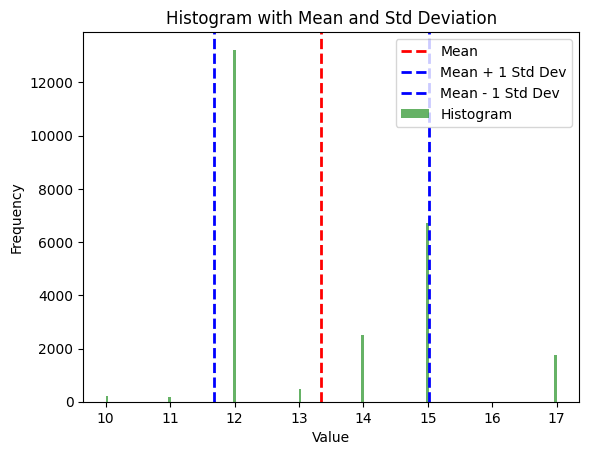

In [76]:
plot_histogram(h_hist, h_bin_edges)

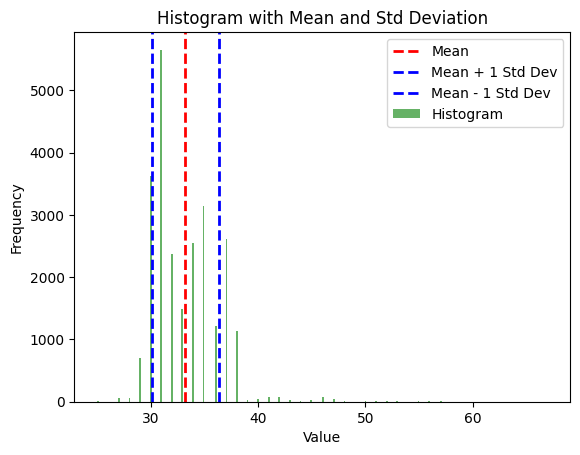

In [77]:
plot_histogram(s_hist, s_bin_edges)

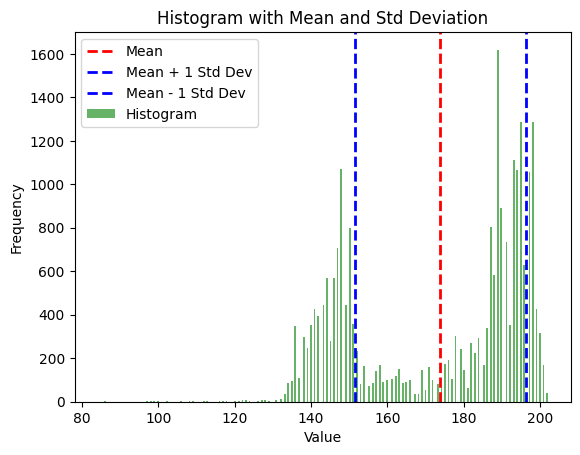

In [78]:
plot_histogram(v_hist, v_bin_edges)

In [79]:
hs_gaussian = create_2d_gaussian(h_border_values, s_border_values)
hv_gaussian = create_2d_gaussian(h_border_values, v_border_values)
sv_gaussian = create_2d_gaussian(s_border_values, v_border_values)

In [83]:
lab_images = []
for img in images:
    lab_images.append(change_color_space(img, 'LAB'))

In [84]:
# Choose an image from the list
img = lab_images[0]

In [85]:
# Get image channels
l, a, b = cv2.split(img)

In [86]:
l_border_values = get_border_pixel_values(l, border_width=10)
a_border_values = get_border_pixel_values(a, border_width=10)
b_border_values = get_border_pixel_values(b, border_width=10)

In [87]:
l_hist, l_bin_edges = create_histogram(l_border_values, bins=256)
a_hist, a_bin_edges = create_histogram(a_border_values, bins=256)
b_hist, b_bin_edges = create_histogram(b_border_values, bins=256)

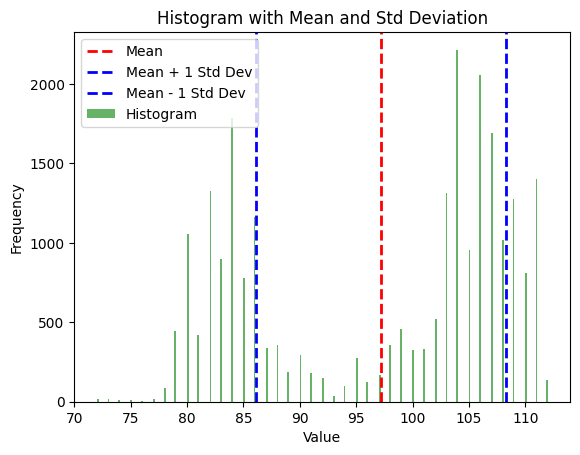

In [88]:
plot_histogram(l_hist, l_bin_edges)

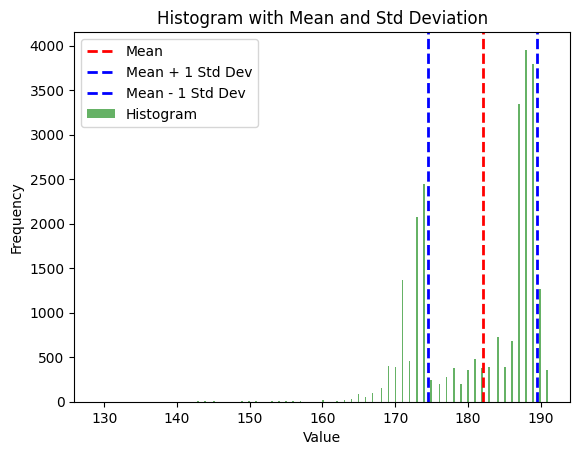

In [89]:
plot_histogram(a_hist, a_bin_edges)

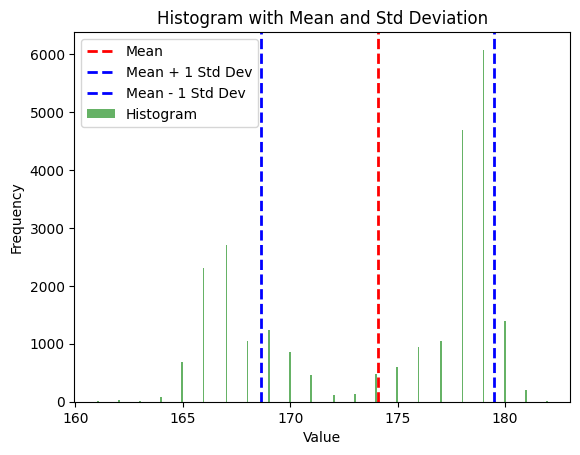

In [90]:
plot_histogram(b_hist, b_bin_edges)

In [91]:
la_gaussian = create_2d_gaussian(l_border_values, a_border_values)
lb_gaussian = create_2d_gaussian(l_border_values, b_border_values)
ab_gaussian = create_2d_gaussian(a_border_values, b_border_values)

## Opening Residue

## Mixture of Gaussians

## Adaptative Threshold

## Otsu's Threshold

## Mean Shift

In [ ]:
def mean_shift(img):
    """
    
    
    
    """

    negative = cv2.bitwise_not(img)
    
    shifted = cv2.pyrMeanShiftFiltering(negative, sp=21, sr=51)

    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_mask_inv = cv2.bitwise_not(binary_mask)


    #Closing and morphological reconstr for further mask improvement
    kernel = np.ones((100, 100), np.uint8)
    binary_mask_closed = cv2.morphologyEx(binary_mask_inv, cv2.MORPH_CLOSE, kernel)

    marker = cv2.erode(binary_mask_closed, np.ones((5, 5), np.uint8))
    reconstruction = cv2.dilate(marker, np.ones((5, 5), np.uint8))

    return reconstruction


In [ ]:
new_masks = []
for img in images:
    